# Stackoverflow 2018 survey

In this notebook, I will try to explore the [2018 survey of stackoverflow](https://insights.stackoverflow.com/survey) to see languages that developers do combine for theirs skills. 

In [1]:
# imports
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

## Description of the data

In [2]:
df = pd.read_csv('survey_results_public.csv', low_memory=False)
r, c = df.shape
print('{} participated in the survey filling around {} questions'.format(r, c))

df.head()

98855 participated in the survey filling around 129 questions


,Respondent,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,...,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy
0,1,Yes,No,Kenya,No,Employed part-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,...,3 - 4 times per week,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Black or of African descent,25 - 34 years old,Yes,NaN,The survey was an appropriate length,Very easy
1,3,Yes,Yes,United Kingdom,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Database administrator;DevOps specialist;Full-...,...,Daily or almost every day,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",White or of European descent,35 - 44 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy
2,4,Yes,Yes,United States,No,Employed full-time,Associate degree,"Computer science, computer engineering, or sof...",20 to 99 employees,Engineering manager;Full-stack developer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,No,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,Full-stack developer,...,I don't typically exercise,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,35 - 44 years old,No,No,The survey was an appropriate length,Somewhat easy
4,7,Yes,No,South Africa,"Yes, part-time",Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...","10,000 or more employees",Data or business analyst;Desktop or enterprise...,...,3 - 4 times per week,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,18 - 24 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy


## Processing the data
For this dataset, I am mostly interested in the languages of those that participated in the survey. Let's create a dataset whose columns is composed of only the languages

For this, I will use the column **LanguageWorkedWith**. This column contains the different languages used by each user that filled the survey.

In [3]:

def lang(x):
    languages = {}
    if not isinstance(x, str) :
        return {}
    for l in x.split(';'):
        languages[l] = 1;
    return languages
lang = df['LanguageWorkedWith'].apply(lambda x: pd.Series(lang(x)))
print("There are {} different languages".format(lang.shape[1]))
lang.head()

There are 38 different languages


,JavaScript,Python,HTML,CSS,Bash/Shell,C#,SQL,TypeScript,C,C++,...,Rust,Julia,VBA,Perl,Cobol,Visual Basic 6,Delphi/Object Pascal,Hack,Clojure,Ocaml
0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see now, the new dataframe has the value 1 for the languages used by a user and NaN if not. 

#### Dealing with missing values
There are no missing values for the generated `df`. `df` either contains 1 for a user that provides the language used or NaN for all the other rows. However, because of the way `df` is generated, we might end up with some rows where all the values are `NaN` if the value for the column `LanguageWorkedWith` for that particular row was previously empty. Let's therefore continue the processing of the data by dealing with the `NaN` values.

#### Dealing with NaN values
To continue our processing, let's remove the rows containing only NaN values which means that the user did not provide the language used. We want to retain a dataset of user who provided the languages they used. `df` will still contains NaN values. We will replace all the NaN by 0 indicating that the user did not use that programing language. We are left off with a dataframe with binary data ( 1 the user uses the programming language and 0 if not).

In [4]:
# remove rows with all to be NaN

missing_sum = lang.isnull().sum(axis = 1)
lang = lang[missing_sum / lang.shape[1] < 1]


lang.head()

,JavaScript,Python,HTML,CSS,Bash/Shell,C#,SQL,TypeScript,C,C++,...,Rust,Julia,VBA,Perl,Cobol,Visual Basic 6,Delphi/Object Pascal,Hack,Clojure,Ocaml
0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# encode NaN to be 0
lang = lang.fillna(0)
lang.head()

,JavaScript,Python,HTML,CSS,Bash/Shell,C#,SQL,TypeScript,C,C++,...,Rust,Julia,VBA,Perl,Cobol,Visual Basic 6,Delphi/Object Pascal,Hack,Clojure,Ocaml
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Number of users for each language

Text(0,0.5,'count')

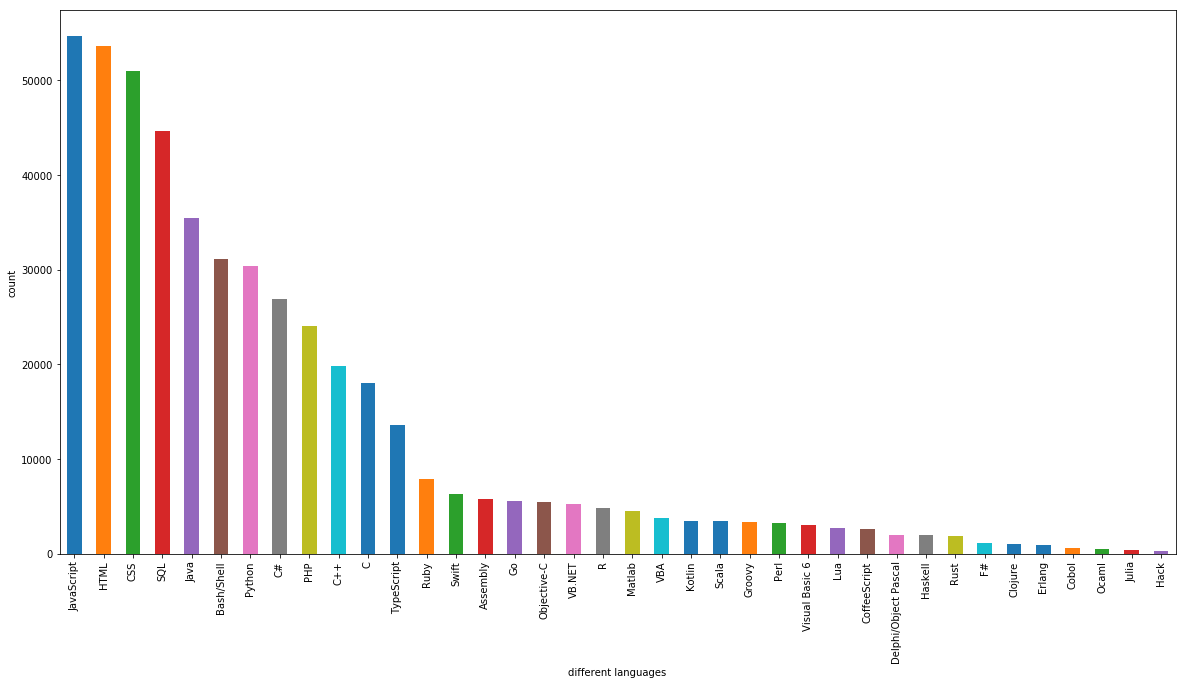

In [6]:
ax = lang.sum().sort_values(ascending=False).plot(kind="bar", figsize=(20, 10))
ax.set_xlabel("different languages")
ax.set_ylabel("count")

## Answering questions

### Question 1: How many categories of user can we make using related languages for their skills ?

#### Clustering the data
We want to find out the clusters we can create with the dataset by using the KMeans clustering algorithm. Let's draw the elbow curbe of the data to find out how many clusters to create

In [7]:
def kmeans_score(data, center):
    """
    Compute k-means score.

    Parameters
    ----------
    data : pd.dataframe
        dataframe to cluster.
    center : int
        number of clusters

    Returns
    -------
    score : numpy.ndarray, scalar
        score of the k-means model
    """
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    
    return score

print(kmeans_score.__doc__)


    Compute k-means score.

    Parameters
    ----------
    data : pd.dataframe
        dataframe to cluster.
    center : int
        number of clusters

    Returns
    -------
    score : numpy.ndarray, scalar
        score of the k-means model
    


In [8]:
def elbow_curbe(centers, scores) :
    """
    Plot the elbow curbe
    
    Parameters:
    ----------
    centers: list
    numbers of cluster of the model
    
    scores: list
    score for each cluster
    
    """
    plt.plot(centers, scores, linestyle='--', marker='o', color='b');
    plt.xlabel('K');
    plt.ylabel('SSE');
    plt.title('SSE vs. K');
    
print(elbow_curbe.__doc__)


    Plot the elbow curbe
    
    Parameters:
    ----------
    centers: list
    numbers of cluster of the model
    
    scores: list
    score for each cluster
    
    


In [9]:
def compute_centers(df) :
    """
    Investigate the change in within-cluster distance across number of clusters.
    
    Parameters:
    ----------
    df: pd.dataframe
    data used for the clustering
    
    Returns:
    -------
    centers: list
    list of clusters used for the clustering
    
    scores: list
    list of scores for each cluster
    """
    scores = []
    centers = list(range(1,30,3))

    for center in centers:
        scores.append(kmeans_score(df, center))
    return centers, scores

print(compute_centers.__doc__)


    Investigate the change in within-cluster distance across number of clusters.
    
    Parameters:
    ----------
    df: pd.dataframe
    data used for the clustering
    
    Returns:
    -------
    centers: list
    list of clusters used for the clustering
    
    scores: list
    list of scores for each cluster
    


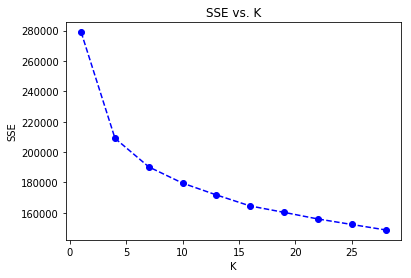

In [10]:
df_lang = lang

centers, scores = compute_centers(df_lang)

elbow_curbe(centers, scores)

### Answer 1: 
looking at the data we can make __15__ categories of sub-related users by their programming languages

### Question 2: What are some top-3 languages that stand out from this categories ?

In [11]:
number_clusters = 15
kmeans = KMeans(number_clusters)
model = kmeans.fit(df_lang)
df_predict = model.predict(df_lang)



In [12]:
# topk languages accross cluster i

def topk_languages(k, i, df, c):
    """
    computes the top-k languages accross each cluster
    
    Parameters:
    ----------
    k: int
    the first (k) languages to be output
    
    i: int
    label of the cluster
    
    df: pd.dataframe
    data used for the clustering
    
    c: list
    columns of the dataset
    
    Returns:
    -------
    dictionary of the first (k) languages accross cluster (i)
    """
    data = df[np.where(df_predict == i)]

    df = pd.DataFrame(data=data,
          index=np.array(range(0, data.shape[0])),
          columns=c)
    return df.sum().sort_values().tail(k).to_dict()

print(topk_languages.__doc__)


    computes the top-k languages accross each cluster
    
    Parameters:
    ----------
    k: int
    the first (k) languages to be output
    
    i: int
    label of the cluster
    
    df: pd.dataframe
    data used for the clustering
    
    c: list
    columns of the dataset
    
    Returns:
    -------
    dictionary of the first (k) languages accross cluster (i)
    


In [13]:
topk_data = []
df_temp = df_lang.as_matrix(columns = df_lang.columns)
for i in range(number_clusters) :
    topk_data.append(topk_languages(3, i, df_temp, df_lang.columns))

topk_data

/home/edoh/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


[{'CSS': 5384.0, 'HTML': 5654.0, 'Java': 5763.0},
 {'JavaScript': 4972.0, 'CSS': 5320.0, 'HTML': 5442.0},
 {'C': 2891.0, 'C++': 3589.0, 'Python': 4239.0},
 {'CSS': 7370.0, 'HTML': 7480.0, 'Bash/Shell': 7597.0},
 {'JavaScript': 1586.0, 'SQL': 1975.0, 'Java': 5458.0},
 {'JavaScript': 1843.0, 'SQL': 2387.0, 'C#': 2778.0},
 {'Java': 1113.0, 'C++': 1962.0, 'C': 2589.0},
 {'CSS': 6801.0, 'HTML': 6996.0, 'SQL': 7140.0},
 {'CSS': 7634.0, 'HTML': 7774.0, 'PHP': 7856.0},
 {'CSS': 6706.0, 'HTML': 6911.0, 'Python': 7004.0},
 {'Java': 557.0, 'Objective-C': 1654.0, 'Swift': 1771.0},
 {'CSS': 5014.0, 'HTML': 5140.0, 'Bash/Shell': 5250.0},
 {'CSS': 2181.0, 'VB.NET': 2217.0, 'HTML': 2272.0},
 {'C++': 3921.0, 'CSS': 4199.0, 'HTML': 4327.0},
 {'Bash/Shell': 2354.0, 'SQL': 2460.0, 'Python': 5535.0}]

In [14]:
plt.rcParams['figure.figsize'] = [20, 5]

def display_languages(data) :
    """
    display a bar chart of the top-k languages for some clusters
    """
    ax = pd.DataFrame(data).plot(kind='bar', figsize=(20, 10))
    ax.set_xlabel("clusters")
    ax.set_ylabel("count")
    plt.figure(figsize=(40,20))
    plt.show()

print(display_languages.__doc__)


    display a bar chart of the top-k languages for some clusters
    


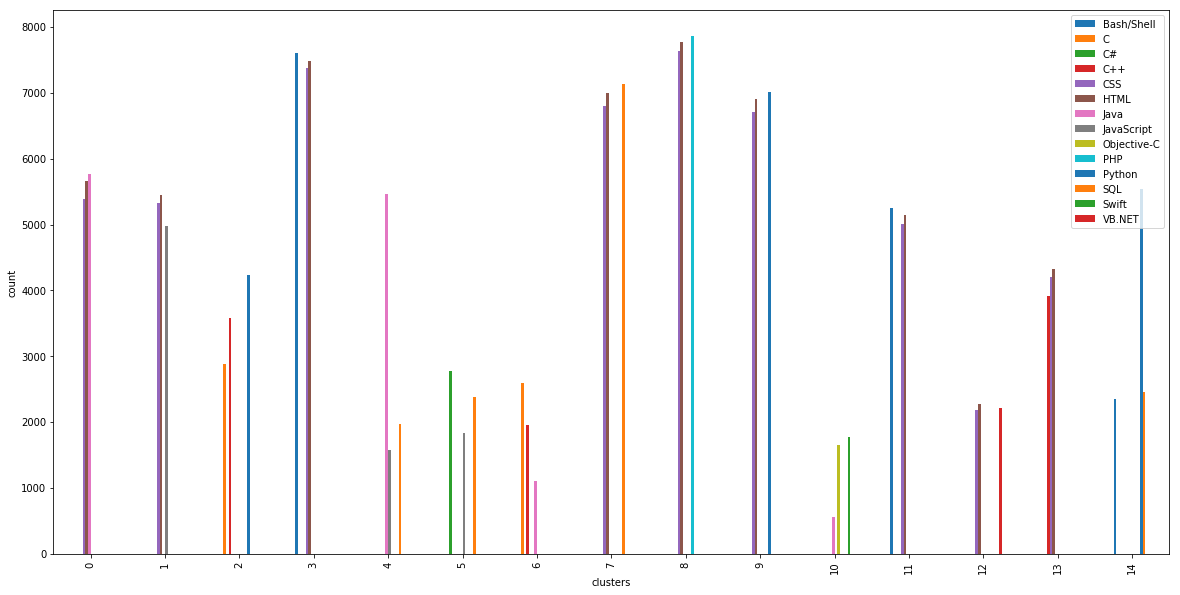

<Figure size 2880x1440 with 0 Axes>

In [15]:
display_languages(topk_data)

#### Analysis of the languages
From the top3 languages accross each languages, one top3 that really stands out is **HTML**, **JavaScript** and **CSS**. It really makes sense to combine those 3 in frontend development. 

But for the rest of the top3, **HTML** and **JavaScript** are always thered and messed up the the results. It also indicates how widely used are those languages. To find out others languages developers are likely to combine, let's remove **HTML**, **JavaScript** and **CSS** columns and redo the clustering

In [16]:
data_trunc = df_lang.drop(['HTML', 'CSS', 'JavaScript'], axis=1)
data_trunc.head()

,Python,Bash/Shell,C#,SQL,TypeScript,C,C++,Java,Matlab,R,...,Rust,Julia,VBA,Perl,Cobol,Visual Basic 6,Delphi/Object Pascal,Hack,Clojure,Ocaml
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


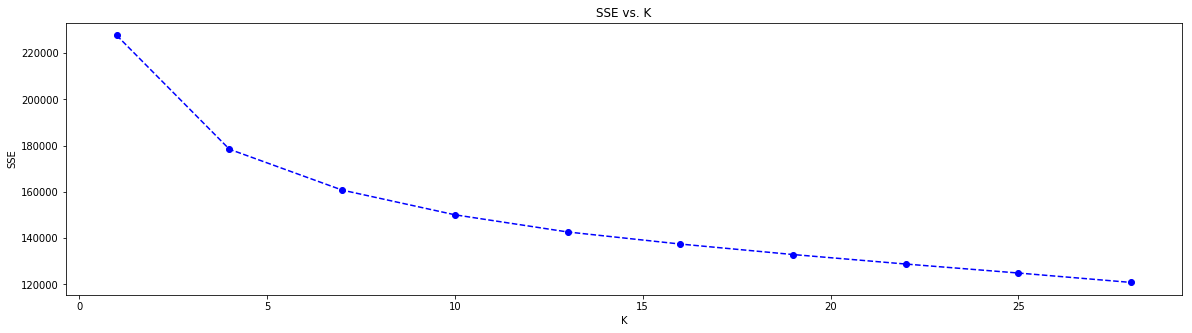

In [17]:
centers, scores = compute_centers(data_trunc)

elbow_curbe(centers, scores)

In [18]:
topk_data = []
df_trunc_temp = data_trunc.as_matrix(columns = data_trunc.columns)
for i in range(number_clusters) :
    topk_data.append(topk_languages(3, i, df_trunc_temp, data_trunc.columns))

topk_data

/home/edoh/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


[{'Bash/Shell': 2659.0, 'SQL': 3391.0, 'Java': 5763.0},
 {'Python': 1121.0, 'TypeScript': 1559.0, 'C#': 1634.0},
 {'C': 2891.0, 'C++': 3589.0, 'Python': 4239.0},
 {'SQL': 6292.0, 'PHP': 6911.0, 'Bash/Shell': 7597.0},
 {'Bash/Shell': 1045.0, 'SQL': 1975.0, 'Java': 5458.0},
 {'C++': 803.0, 'SQL': 2387.0, 'C#': 2778.0},
 {'Java': 1113.0, 'C++': 1962.0, 'C': 2589.0},
 {'TypeScript': 2670.0, 'C#': 6445.0, 'SQL': 7140.0},
 {'Java': 2513.0, 'SQL': 5415.0, 'PHP': 7856.0},
 {'SQL': 4565.0, 'Bash/Shell': 5294.0, 'Python': 7004.0},
 {'Java': 557.0, 'Objective-C': 1654.0, 'Swift': 1771.0},
 {'C++': 4666.0, 'C': 4808.0, 'Bash/Shell': 5250.0},
 {'C#': 2091.0, 'SQL': 2133.0, 'VB.NET': 2217.0},
 {'Java': 3516.0, 'C': 3665.0, 'C++': 3921.0},
 {'Bash/Shell': 2354.0, 'SQL': 2460.0, 'Python': 5535.0}]

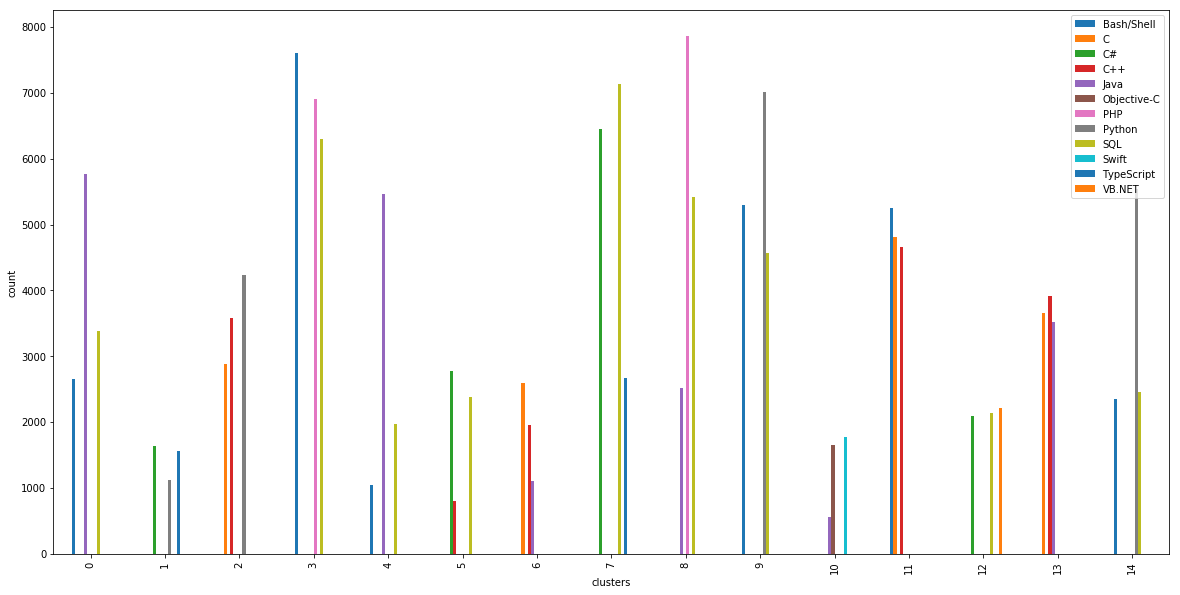

<Figure size 2880x1440 with 0 Axes>

In [19]:
display_languages(topk_data)

#### Analysis of the results

One top3  that really stands out for me here is __Python__, <b>C</b> and __C++__, intuitively, I want to add __C--__ as well :) . It means that developers who uses __Python__ are likely to use <b>C</b> and __C++__ as well. Well, but in which field does that happen ? In data-science it is easier to combine those three skills for instance when writing and deploying deep-learning models
Another top-3 here worth mentionning is __TypeScript__, __C#__ and __SQL__. Those three are likely to be mastered by full-stack developpers using __SQL__ as their database __C#__ for the backend and __TypeScript__ with a framework such as Angular for the frontend

### Answer 2: 

Accross the clusters, these top-3 came out:

- HTML, CSS and JavaScript
- Python, C and C++
- TypeScript, C# and SQL

### Question 3: Which other languages a user will likely use after mastering go ?

To answer this question will try to find the cluster with the highest number of go developers and we will see which other languages come first in that cluster

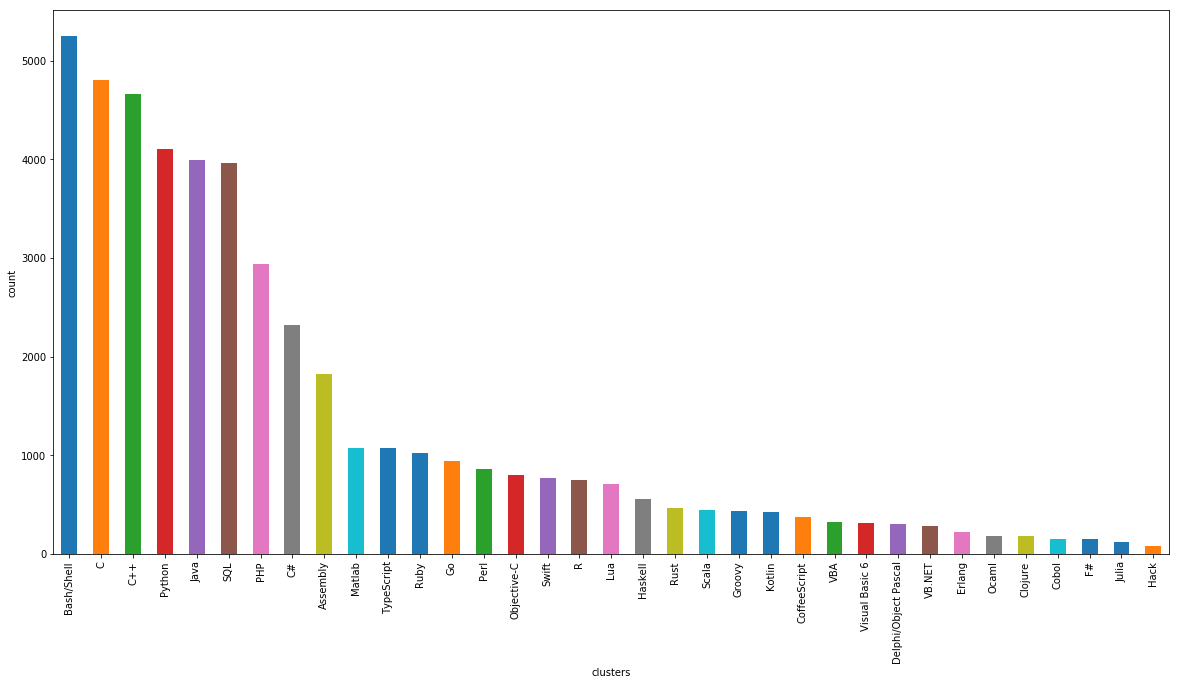

In [20]:
def related_languages(df, lang, clusters, c):
    """
    plot a bar chart of the languages in the cluster with highest number of users of (lang)
    
    Parameters:
    ----------
    df: numpy.ndarray
    dataset used
    
    lang: string
    language of interest
    
    clusters: int
    number of clusters
    
    c: array-like
    columns of the dataset
    """
    records = []
    # find the cluster with highest number of user
    for i in range(clusters) :
        data = df[np.where(df_predict == i)]

        temp = pd.DataFrame(data=data,
              index=np.array(range(0, data.shape[0])),
              columns=c)
        
        records.append({'cluster': i, 'count': temp[lang].sum()})
    
    label = sorted(records, key=lambda k: k['count'], reverse=True)[0]['cluster']
    
    # sum over all the different languages of the cluster
    data = df[np.where(df_predict == label)]
    df = pd.DataFrame(data=data,
              index=np.array(range(0, data.shape[0])),
              columns=c)
    
    # plot the bar chart
    ax = df.sum().sort_values(ascending=False).plot(kind='bar', figsize=(20, 10))
    ax.set_xlabel("clusters")
    ax.set_ylabel("count")
    plt.show()
    
related_languages(df_trunc_temp, 'Go', number_clusters, data_trunc.columns)
        

### Answer 3 : 
We can see from the chart that the user of __Go__ are in a cluster with users who master __Bash/Shell__, <b>C</b>, <b>C++</b> and __Python__.

## Conclusion

Developers rarely master only one programming language. They are likely to master as many as they can. But generally those languages learned should have something in common, ie related to the same field, using almost the same paradigm of coding. In this notebook we tried to discover some of the trend amond developers. I was mostly interested in Python and go, because they are languages that I do use. Well the clusters provided some insights on other related languages like <b>C</b>, <b>C++</b>, __Bash/shell__